<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Project Overview

We want to understand product sales patterns in a retail business.  
In this notebook, I will be exploring questions such as:

- Which products sell well?
- Which categories dominate in which months?  
- Is there any seasonality or segmentation opportunity?  

</div>

In [1]:
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Data Overview

</div>

In [2]:
conn = sqlite3.connect("../data/northwind.db")

In [3]:
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)

tables

,name
0,Categories
1,CustomerCustomerDemo
2,CustomerDemographics
3,Customers
4,EmployeeTerritories
5,Employees
6,Order Details
7,Orders
8,Products
9,Regions


In [4]:
table_names = tables['name'].tolist()
for name in table_names:
    try:
        count = pd.read_sql(f"SELECT COUNT(*) AS count FROM [{name}];", conn)
        print(f"{name:25}: {count['count'].iloc[0]} rows")
    except:
        print(f"{name:25}: (error reading)")

Categories               : 8 rows
CustomerCustomerDemo     : 0 rows
CustomerDemographics     : 0 rows
Customers                : 93 rows
EmployeeTerritories      : 49 rows
Employees                : 9 rows
Order Details            : 609283 rows
Orders                   : 16282 rows
Products                 : 77 rows
Regions                  : 4 rows
Shippers                 : 3 rows
Suppliers                : 29 rows
Territories              : 53 rows
sqlite_sequence          : 6 rows


<div style="background-color:#e6f4ea; padding:10px; border:1px solid #ccc; border-radius:5px;">
There are 14 tables in northwind.db.

We use the Northwind database and begin by extracting key tables with SQL.

</div>

In [5]:
pd.read_sql("PRAGMA table_info([Order Details]);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,OrderID,INTEGER,1,None,1
1,1,ProductID,INTEGER,1,None,2
2,2,UnitPrice,NUMERIC,1,0,0
3,3,Quantity,INTEGER,1,1,0
4,4,Discount,REAL,1,0,0


In [6]:
pd.read_sql("PRAGMA table_info([Categories]);", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,CategoryID,INTEGER,0,None,1
1,1,CategoryName,TEXT,0,None,0
2,2,Description,TEXT,0,None,0
3,3,Picture,BLOB,0,None,0


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# EDA

</div>

In [7]:
sql='''
SELECT COUNT(DISTINCT ProductID) AS num_products_sold
FROM [Order Details];
'''
result = pd.read_sql(sql, conn)
result

,num_products_sold
0,77


In [8]:
# Aggregates purchase count, average unit price, total quantity, total sales, and average discount per ProductID.

sql='''
SELECT
    p.ProductID,
    p.ProductName,
    COUNT(od.OrderID) AS purchase_count,
    ROUND(AVG(od.UnitPrice), 2) AS avg_unit_price,
    ROUND(SUM(od.Quantity), 2) AS total_quantity,
    ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS total_sales,
    ROUND(AVG(od.Discount), 2) AS avg_discount
FROM [Order Details] od
LEFT OUTER JOIN Products p ON od.ProductID = p.ProductID
GROUP BY p.ProductID, p.ProductName
ORDER BY purchase_count DESC;
'''

result = pd.read_sql(sql, conn)
result

,ProductID,ProductName,purchase_count,avg_unit_price,total_quantity,total_sales,avg_discount
0,66,Louisiana Hot Spiced Okra,8040,17.00,206213.0,3504941.00,0.0
1,19,Teatime Chocolate Biscuits,8024,9.20,205487.0,1889691.42,0.0
2,70,Outback Lager,8020,15.00,204403.0,3064462.65,0.0
3,20,Sir Rodney's Marmalade,7999,80.99,205637.0,16653807.36,0.0
4,26,Gumbär Gummibärchen,7999,31.22,204761.0,6391018.98,0.0
...,...,...,...,...,...,...,...
72,14,Tofu,7834,23.24,199834.0,4644738.99,0.0
73,68,Scottish Longbreads,7818,12.50,202349.0,2528089.00,0.0
74,32,Mascarpone Fabioli,7817,32.00,199441.0,6381012.16,0.0
75,53,Perth Pasties,7817,32.79,200146.0,6561681.37,0.0


In [20]:
# Calculates monthly and yearly sales metrics per CategoryName using CTEs and joins for time-based comparison.
# We look at monthly sales and customer counts to explore seasonality.

query = """
WITH monthly AS (
    SELECT
        cat.CategoryName,
        strftime('%Y%m', o.OrderDate) AS YYYYMM,
        strftime('%Y', o.OrderDate) AS YYYY,
        ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS TotalSalesMonth,
        COUNT(DISTINCT o.CustomerID) AS UniqueCustomersMonth
    FROM [Order Details] od
    LEFT OUTER JOIN Products p ON od.ProductID = p.ProductID
    LEFT OUTER JOIN Categories cat ON p.CategoryID = cat.CategoryID
    LEFT OUTER JOIN Orders o ON od.OrderID = o.OrderID
    GROUP BY 1,2
),
yearly AS (
    SELECT
        cat.CategoryName,
        strftime('%Y', o.OrderDate) AS YYYY,
        ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS TotalSalesYear,
        COUNT(DISTINCT o.CustomerID) AS UniqueCustomersYear
    FROM [Order Details] od
    LEFT OUTER JOIN Products p ON od.ProductID = p.ProductID
    LEFT OUTER JOIN Categories cat ON p.CategoryID = cat.CategoryID
    LEFT OUTER JOIN Orders o ON od.OrderID = o.OrderID
    GROUP BY 1,2
)
SELECT
    m.CategoryName,
    m.YYYYMM,
    m.YYYY,
    m.TotalSalesMonth,
    m.UniqueCustomersMonth,
    y.TotalSalesYear,
    y.UniqueCustomersYear
FROM monthly m
LEFT OUTER JOIN yearly y ON 
    ( m.CategoryName = y.CategoryName AND m.YYYY = y.YYYY ) 
GROUP BY 1,2
"""
category_sales = pd.read_sql(query, conn)
category_sales

,CategoryName,YYYYMM,YYYY,TotalSalesMonth,UniqueCustomersMonth,TotalSalesYear,UniqueCustomersYear
0,Beverages,201207,2012,"422,541.00",47,"3,832,061.25",93
1,Beverages,201208,2012,"717,189.75",66,"3,832,061.25",93
2,Beverages,201209,2012,"691,794.00",69,"3,832,061.25",93
3,Beverages,201210,2012,"657,336.50",66,"3,832,061.25",93
4,Beverages,201211,2012,"622,583.00",59,"3,832,061.25",93
...,...,...,...,...,...,...,...
1083,Seafood,202306,2023,"341,981.66",55,"3,744,024.40",93
1084,Seafood,202307,2023,"385,273.61",65,"3,744,024.40",93
1085,Seafood,202308,2023,"371,421.60",60,"3,744,024.40",93
1086,Seafood,202309,2023,"406,647.48",65,"3,744,024.40",93


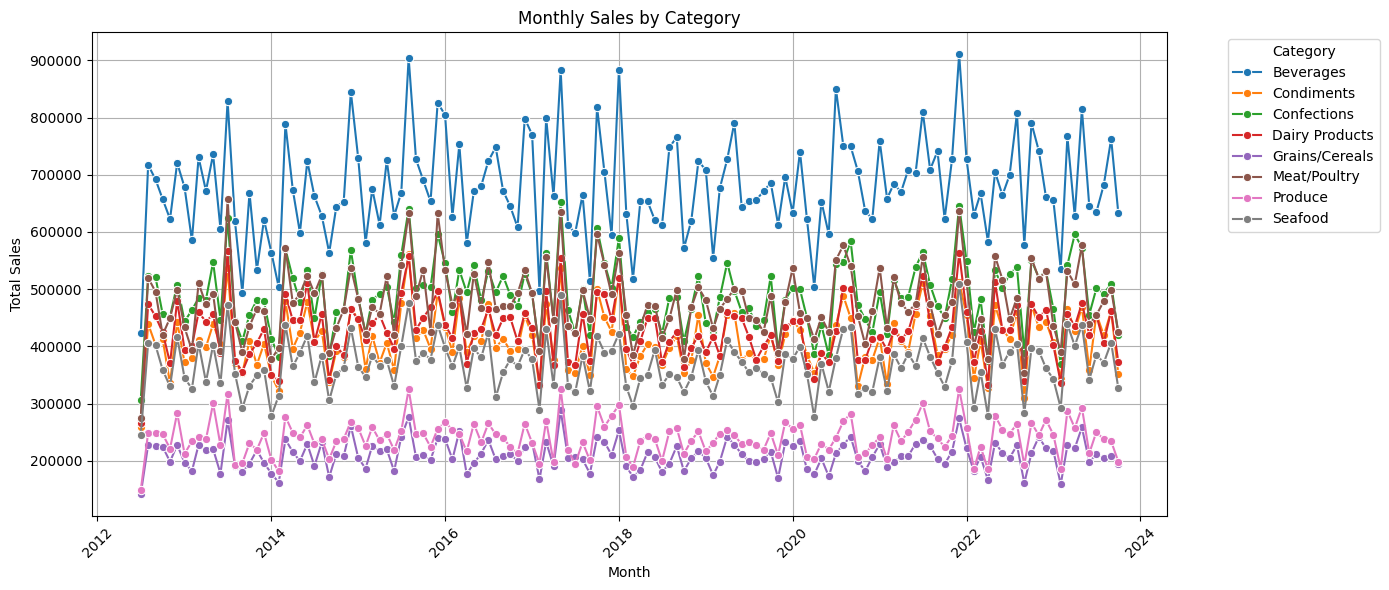

In [19]:
# Visualize the results of the above SQL

category_sales['YYYYMM'] = pd.to_datetime(category_sales['YYYYMM'], format='%Y%m')

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=category_sales,
    x='YYYYMM',
    y='TotalSalesMonth',
    hue='CategoryName',
    marker='o'
)

plt.title('Monthly Sales by Category')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Modeling ( KMeans Clustering )

To explore product types, I grouped the products using how often they are bought and their average price.
<br>
I made 3 types of product groups.

# Product Clustering

We use KMeans to group products based on how often they are purchased and their average unit price.  
This helps us identify different types of product roles — such as high-volume staples or niche premium items.


</div>

In [9]:
features = result[['purchase_count', 'avg_unit_price']].copy()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=10, n_init='auto')
result['cluster'] = kmeans.fit_predict(scaled_features)

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Cluster Analysis

</div>

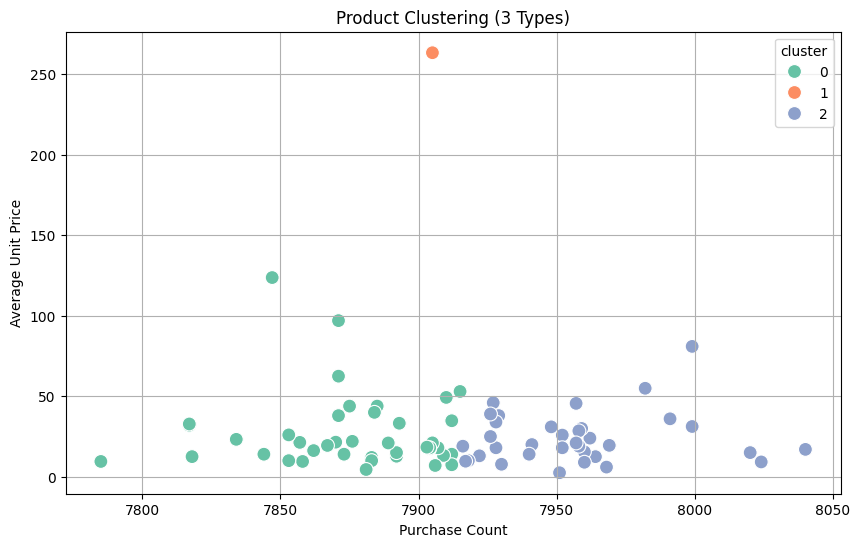

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='purchase_count',
    y='avg_unit_price',
    hue='cluster',
    data=result,
    palette='Set2',
    s=100
)
plt.title('Product Clustering (3 Types)')
plt.xlabel('Purchase Count')
plt.ylabel('Average Unit Price')
plt.grid(True)
plt.show()

<div style="background-color:#e6f4ea; padding:10px; border:1px solid #ccc; border-radius:5px;">
This chart shows that the products are divided into three groups based on their average price and number of purchases.


This chart visualizes product clustering based on two key features: 
- the average unit price
- the total number of purchases
  
Each point represents a single product, and the products have been grouped into three distinct clusters using the KMeans algorithm.  
The clustering helps reveal patterns in product behavior — such as frequently purchased low-price items, rare but high-priced products, and those that fall somewhere in between.  
This segmentation can support strategic decisions in pricing, inventory, or marketing.



</div>

In [11]:
result[result['cluster'] == 0][['ProductName', 'purchase_count', 'avg_unit_price']].sort_values(by='avg_unit_price', ascending=False)


,ProductName,purchase_count,avg_unit_price
70,Thüringer Rostbratwurst,7847,123.76
60,Mishi Kobe Niku,7871,97.00
61,Carnarvon Tigers,7871,62.49
35,Manjimup Dried Apples,7915,52.99
39,Tarte au sucre,7910,49.28
52,Schoggi Schokolade,7885,43.90
58,Vegie-spread,7875,43.89
53,Northwoods Cranberry Sauce,7884,40.00
62,Gnocchi di nonna Alice,7871,37.98
38,Mozzarella di Giovanni,7912,34.79


In [17]:
# Calculates and displays the category-wise sales contribution (as a percentage of total sales) within each product cluster,
# helping to understand the composition of each cluster.

pd.options.display.float_format = '{:,.2f}'.format
cluster_category = (
    merged.groupby(['cluster', 'CategoryName'])['total_sales']
    .sum()
    .reset_index()
)

cluster_total = (
    merged.groupby('cluster')['total_sales']
    .sum()
    .reset_index()
    .rename(columns={'total_sales': 'cluster_total_sales'})
)

cluster_category = cluster_category.merge(cluster_total, on='cluster')
cluster_category['category_sales_ratio'] = (
    cluster_category['total_sales'] / cluster_category['cluster_total_sales']
).round(3)

cluster_category = cluster_category.sort_values(
    ['cluster', 'CategoryName'],
    ascending=[True, True]
).reset_index(drop=True)

display(cluster_category)

# Check the total of category_sales_ratio for each cluster (check if it is equal to 1.00)
print(cluster_category.groupby('cluster')['category_sales_ratio'].sum().round(3))


,cluster,CategoryName,total_sales,cluster_total_sales,category_sales_ratio
0,0,Beverages,"11,002,164.26","223,425,891.15",0.05
1,0,Condiments,"33,642,103.23","223,425,891.15",0.15
2,0,Confections,"37,381,360.70","223,425,891.15",0.17
3,0,Dairy Products,"21,936,519.59","223,425,891.15",0.10
4,0,Grains/Cereals,"18,563,103.23","223,425,891.15",0.08
5,0,Meat/Poultry,"52,117,317.19","223,425,891.15",0.23
6,0,Produce,"17,330,100.14","223,425,891.15",0.08
7,0,Seafood,"31,453,222.81","223,425,891.15",0.14
8,1,Beverages,"53,265,895.23","53,265,895.23",1.00
9,2,Beverages,"27,895,124.68","171,694,846.81",0.16


cluster
0   1.00
1   1.00
2   1.00
Name: category_sales_ratio, dtype: float64
